In [6]:
from __future__ import annotations

import sys
sys.path.append("../StateVecSimulator/latte")
sys.path.append("../StateVecSimulator")

import numpy as np

import simulation
import importlib
import _vec_intercept_sampler
import _noise
import vec_sim
importlib.reload(vec_sim)
importlib.reload(simulation)
importlib.reload(_vec_intercept_sampler)
importlib.reload(_noise)
from _vec_intercept_sampler import VecInterceptSampler
from _noise import NoiseModel
from simulation import *
from IPython import display
import matplotlib.pyplot as plt
import stim
import sinter
from tqdm.notebook import tqdm
from pyperclip import copy

In [7]:
rotated_simulation = RotatedSurfaceCodeSimulation(d = 3)
r_init_x_circuit = rotated_simulation.generate_init_circuit(basis = 'x')
r_injection_x_circuit = rotated_simulation.generate_injection_circuit_HXY(init_basis = 'x')
r_double_ghz_circuit_HXY = rotated_simulation.generate_projection_double_ghz_HXY()
r_syndrome_circuit = rotated_simulation.generate_syndrome_circuit()
r_full_double_circuit = r_init_x_circuit + r_injection_x_circuit + r_syndrome_circuit + r_double_ghz_circuit_HXY 

copy(str(r_full_double_circuit.to_stim_circuit(noise_model = None, p = 0)))

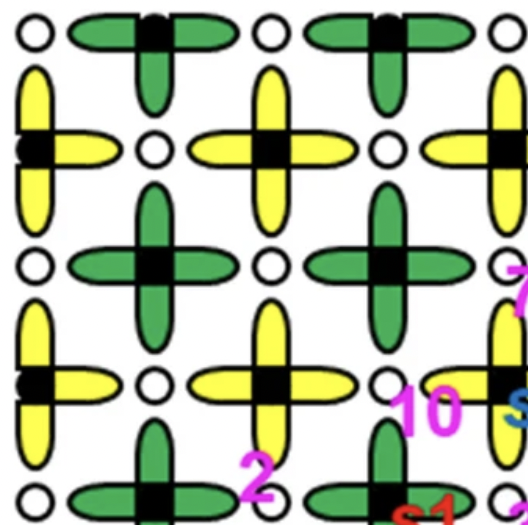

In [3]:
# Crop image to 50% width and height while preserving original
from PIL import Image
img = Image.open("./fig/unrotated.png")
width, height = img.size
new_width = width *0.335
new_height = height * 0.5
cropped_img = img.crop((0, 0, new_width, new_height))
cropped_img.save("./fig/unrotated_cropped.png")
display.Image("./fig/unrotated_cropped.png", width=300, height=300)

In [4]:
simulation = Simulation(d = 3)
rotated_simulation = RotatedSurfaceCodeSimulation(d = 3)

In [5]:
injection = rotated_simulation.generate_injection_circuit_HXY(init_basis = "z")

In [6]:
ghz_circuit = simulation.generate_projection_circuit(generate_unitary = False)
ghz_circuit_HXY = simulation.generate_projection_circuit_HXY(generate_unitary = False)
syndrome_circuit = simulation.generate_syndrome_circuit(generate_unitary = False)
double_ghz_circuit = simulation.generate_double_ghz(generate_unitary = False)
double_ghz_circuit_HXY = simulation.generate_double_ghz_HXY(generate_unitary = False)
injection_circuit = simulation.generate_injection_circuit(generate_unitary = False)
injection_circuit_HXY = simulation.generate_injection_circuit_HXY(init_basis = "z") 

In [7]:
full_circ = syndrome_circuit + injection_circuit_HXY + syndrome_circuit + double_ghz_circuit_HXY 

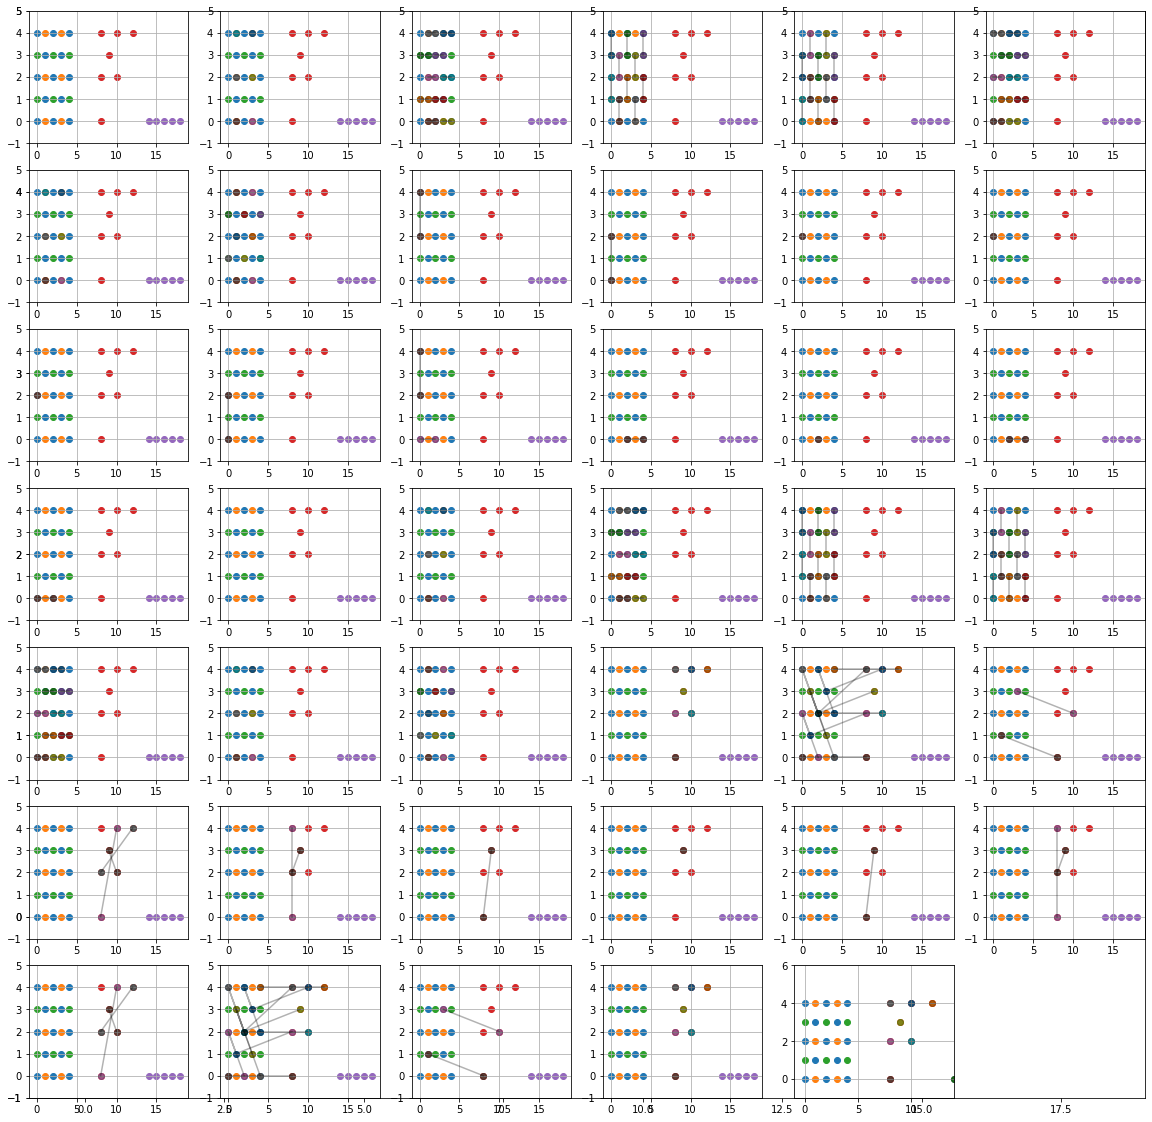

In [9]:
full_circ.plot_timeline()

In [7]:
full_circuit = simulation.generate_syndrome_circuit(generate_unitary = False, detect_x = False) + ghz_circuit + syndrome_circuit + ghz_circuit + syndrome_circuit + ghz_circuit
full_circuit_injection_ghz = simulation.generate_syndrome_circuit(generate_unitary = False, detect_x = False) + injection_circuit + ghz_circuit 

short_double_injection_ghz_circuit =  simulation.generate_syndrome_circuit(generate_unitary = False, detect_x = False) + injection_circuit + syndrome_circuit +double_ghz_circuit 
short_double_injection_ghz_HXY_circuit = simulation.generate_syndrome_circuit(generate_unitary = False, detect_x = False) + injection_circuit_HXY + syndrome_circuit + double_ghz_circuit_HXY 


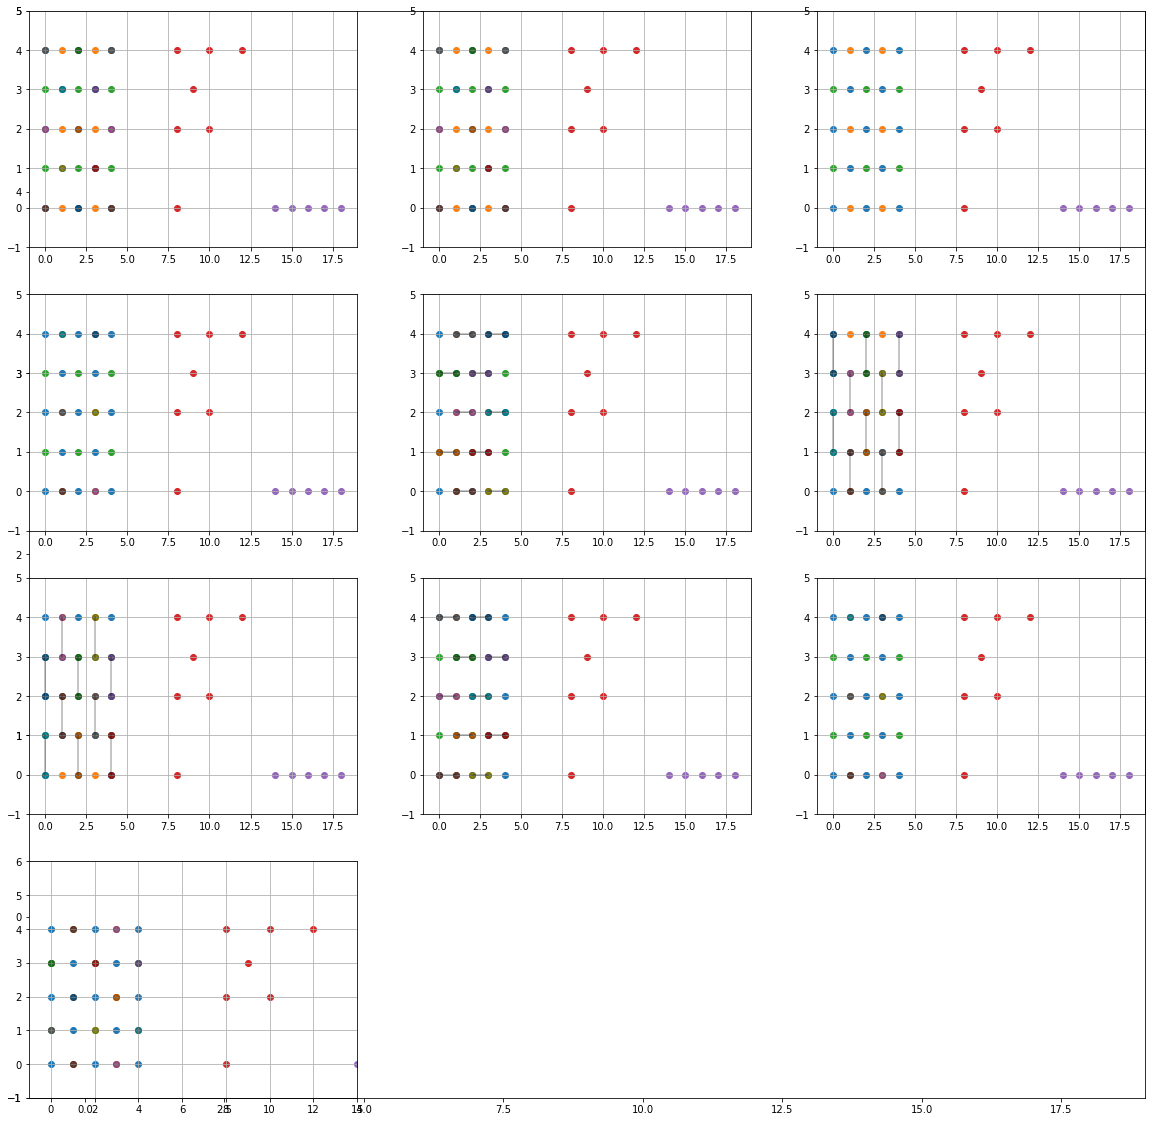

In [9]:
simulation.generate_init_circuit(basis = 'x').plot_timeline()

In [10]:
from pyperclip import copy
full_stim = full_circuit.to_stim_circuit(measure_logical_operator=False,
                                         post_select_syndromes=False,
                                         apply_non_cliffords=False,
                                         non_clifford_noise_strategy="CZ") + simulation.stim_expansion_circuit(d2 = 5, rounds = 1)

In [11]:
copy(str(full_stim))

In [13]:
test_hxy_circuit = simulation.generate_syndrome_circuit(generate_unitary = False, detect_x = False) + injection_circuit_HXY  + double_ghz_circuit_HXY
test_hxy_circuit = simulation.generate_syndrome_circuit(generate_unitary = False, detect_x = False) + injection_circuit_HXY  + ghz_circuit_HXY

In [ ]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

parallel = Parallel(n_jobs = -1)

ps = [0, 1e-3, 2e-3, 4e-3]
# ps = [0]#, 1e-3, 2e-3, 4e-3]
shots_per_batch = 10
total_shots = 50
num_batches = total_shots // shots_per_batch
post_select_syndromes = True

# circuit = short_double_injection_ghz_circuit
# final_state = 'H'

circuit = test_hxy_circuit 
final_state = 'HXY'

# Pre-compile all samplers
samplers = {}
for p in ps:
    if p == 0:
        noise_model = None
    else:
        noise_model = NoiseModel.uniform_depolarizing(p=p)
    task = sinter.Task(circuit=circuit.to_stim_circuit(noise_model, p, post_select_syndromes = post_select_syndromes))
    samplers[p] = VecInterceptSampler(
        logical_x=[q.index for q in simulation.logical_x_qubits],
        logical_z=[q.index for q in simulation.logical_z_qubits]).compiled_sampler_for_task(task)

results = []
for batch in tqdm(range(num_batches)):
    # Cycle through all ps in each batch
    for p in tqdm(ps, leave = False):
        batch_results = parallel(delayed(samplers[p].sample)(shots=1, measured_operator = final_state) for _ in range(shots_per_batch))
        batch_results = sum(batch_results[1:], batch_results[0])  # Flatten results
        
        # Add metadata and save results
        results.append({
                'p': p,
                'batch': batch,
                'shots':  batch_results.shots,
                'discards' : batch_results.discards,
                'errors' : batch_results.errors
        })
        print(results[-1])
        

 20%|██        | 1/5 [00:30<02:03, 31.00s/it]

{'p': 0, 'batch': 0, 'shots': 10, 'discards': 0, 'errors': 0}


 20%|██        | 1/5 [00:50<03:21, 50.25s/it]


KeyboardInterrupt: 

In [88]:
test_hxy_circuit.to_stim_circuit(noise_model = None, p = 0, post_select_syndromes = True).to_file("./circuits/test_circuits/test_hxy_circuit.stim")

In [5]:
import stim
from pyperclip import copy

In [6]:
copy(str(stim.Circuit.generated("surface_code:unrotated_memory_z", distance = 5, rounds = 3)))